# E-commerce Product Design A/B testing 

## 1.Desinging our experiment 
- Creating a hypothesis
    - Two tailed test
    - Confidence level of 95% (α = 0.05)
<br></br>

- Choosing the variables
    - Control group
    - Treatment group
<br></br>
- Choosing a sample size 



## Choosing a sample size

In [11]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from matplotlib.font_manager import FontProperties

%matplotlib inline

# Some plot styling preferences
sns.set_style('whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)   

 # Calculating sample size needed 
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                
# Rounding up to next whole number 
required_n = ceil(required_n)                                                   


print(required_n)

4720


## 2. Collecting and preparing the data

### Loading the data


In [12]:
file_path = 'ab_data.csv'
df = pd.read_csv(file_path)
print(df)

        user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[294478 rows x 5 columns]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### Checking the distribution of data


In [32]:
# showing min and max values to spot unusual date
min_timestamp = df['timestamp'].min()
max_timestamp = df['timestamp'].max()

print(f"Minimum Timestamp: {min_timestamp}")
print(f"Maximum Timestamp: {max_timestamp}")

Minimum Timestamp: 2017-01-02 13:42:05.378582
Maximum Timestamp: 2017-01-24 13:41:54.460509


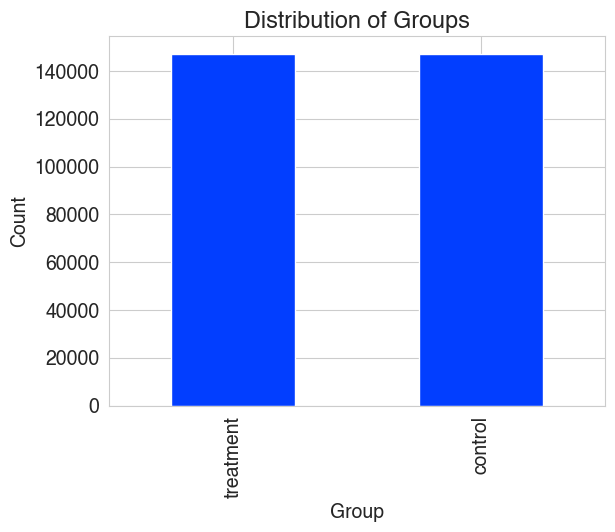

In [15]:
# Showing the distribution of groups 
fig, ax3 = plt.subplots()
df['group'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Distribution of Groups')
ax3.set_xlabel('Group')
ax3.set_ylabel('Count')
plt.show()

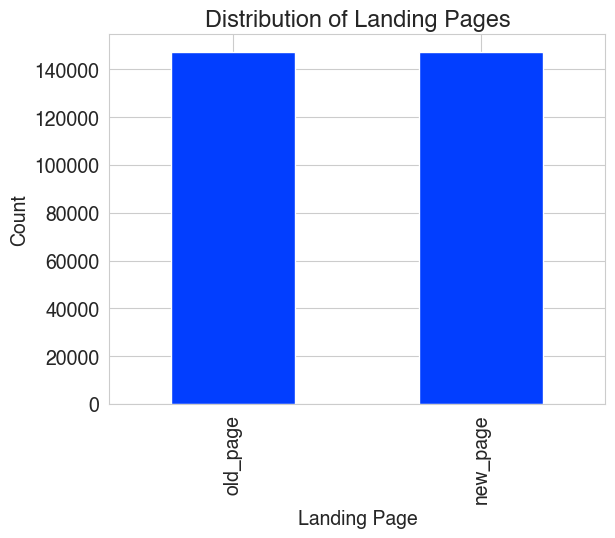

In [16]:
# Showing the distribution of groups 
df['landing_page'].value_counts().plot(kind='bar')
plt.title('Distribution of Landing Pages')
plt.xlabel('Landing Page')
plt.ylabel('Count')
plt.show()

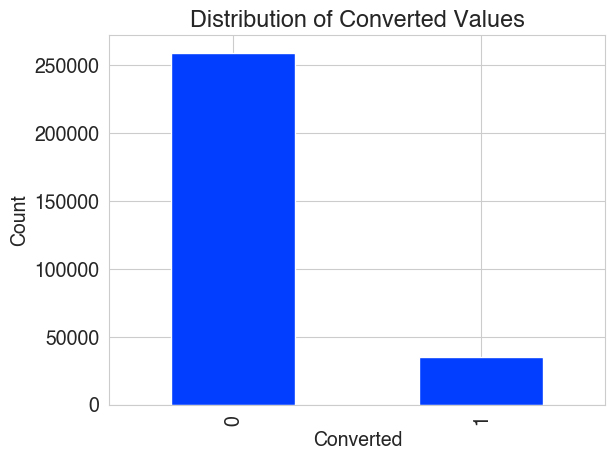

In [36]:
# Showing the distribution of converted values
# 0 - The user did not buy the product during this user session
# 1 - The user bought the product during this user session

df['converted'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Converted Values')
plt.xlabel('Converted')
plt.ylabel('Count')
plt.show()

In [37]:
# Making sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [19]:
# Checking the count of occurence 
session_counts = df['user_id'].value_counts(ascending=False)

# Getting the number of users that have multiple sessions
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [20]:
drop_users = session_counts[session_counts > 1].index
new_df = df[~df['user_id'].isin(drop_users)]
print(f'After dropping there are {new_df.shape[0]} entries left')

After dropping there are 286690 entries left


In [38]:
pd.crosstab(new_df['group'], new_df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## Sampling

In [23]:
# Setting random_state for reproducibility 
control_sample = new_df[new_df['group'] == 'control'].sample(n = required_n, random_state = 22)
treatment_sample = new_df[new_df['group'] == 'treatment'].sample(n = required_n, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [24]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


## 3. Visualizing the results

### Basic statistics 

In [25]:
# conversion rate
conversion_rates = ab_test.groupby('group')['converted']

# standard deviation of the proportion 
std_p = lambda x: np.std(x, ddof = 0)

# standard deviation error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof = 0)

conversion_rates = conversion_rates.agg(['mean', std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


### Visualizing the conversion rate

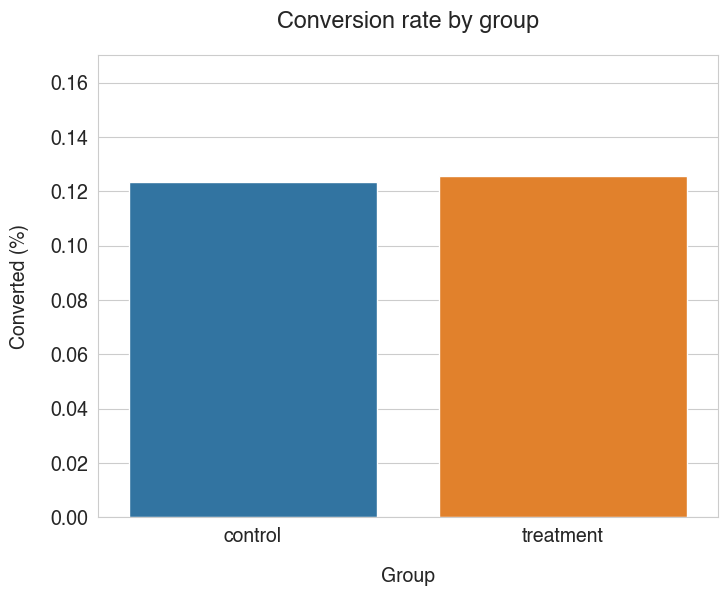

In [27]:
col = sns.color_palette("tab10")

plt.figure(figsize = (8,6))
colors = {'control': 'blue', 'treatment': 'light-orange'}

sns.set_palette("bright")

sns.barplot(x='group', y='converted', data=ab_test, errorbar=('ci', False), palette = 'tab10',hue='group')
font_properties = FontProperties(weight='normal', style='normal')
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad = 15, font_properties = font_properties)
plt.ylabel('Converted (%)', labelpad = 15, font_properties = font_properties);

# 4. Testing the hypothesis

In [29]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group']== 'control']['converted']
treatment_results = ab_test[ab_test['group']== 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

# make a list that has the values of control and treatment conversion counts
successes = [control_results.sum(), treatment_results.sum()]

# total counts (regardless the conversion)
nobs = [n_con, n_treat]

z_stat, p_val = proportions_ztest(successes, nobs)

# alpha stands for significance level
(lower_con, lower_treat),(upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha = 0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.3f}')
print(f'confidence interval 95% for control group: [{lower_con:.3f},{upper_con:.3f}]')
print(f'confidence interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
confidence interval 95% for control group: [0.114,0.133]
confidence interval 95% for treatment group: [0.116, 0.135]


# 5. Drawing conclusions

p-value: 0.181 is above our significance level 0.05, meaning that there is no statistically significant difference in the proportions of the outcome between the two groups.
In other words, __we fail to reject the null hypothesis. The new design couldn't outperform the old design.__

Remember, the baseline of conversion rate for the treatement group was set to 13%, and the target value was 15%. If we look at the confidence interval of the treatment group [0.114, 0.133] is 11.6% - 13.3%, which includes the baseline value 13% but not the target value 15%.

This is further proof that the new design isn't likely to be an improvement on the old desin. Cheers..